In [11]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt 

# Load and prepare data

In [12]:
zri = pd.read_csv('../data/zri_multifamily_v2.csv')
zri['zip'] = zri['zip'].astype('string')
zri['zip'] = ["0"+z if len(z)<5 else z for z in zri['zip']]
zri['year'] = pd.to_datetime(zri['year-month'],format="%Y-%m").dt.year
zri['year-month'] = pd.to_datetime(zri['year-month'],format="%Y-%m")

acs = pd.read_csv('../../../zillow_orientation/acs_5yr_merged_v3.csv')
acs['zip'] = acs['zip'].astype('string')
acs['zip'] = ["0"+z if len(z)<5 else z for z in acs['zip']]
acs['year_used']= acs['year']+2

zri_acs = pd.merge(zri,acs,how='left',left_on=["zip","year"],right_on=["zip","year_used"])
zri_acs = zri_acs.drop(index=zri_acs[zri_acs['zip']=="11249"].index)

In [19]:
data_orig = zri[['year-month','year','zip','zri']]

<AxesSubplot:xlabel='year-month'>

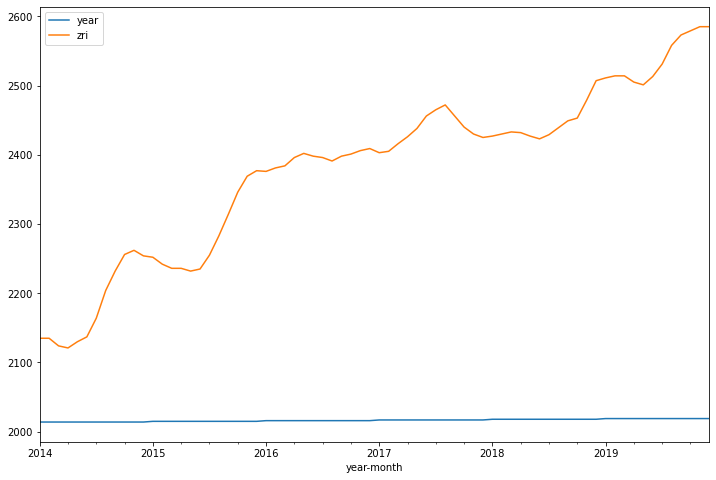

In [20]:
data_orig[data_orig['zip']=="07302"].\
set_index('year-month').plot(figsize=(12,8))

In [23]:
data_lags = pd.DataFrame()
for z in data['zip'].unique():
    data_temp = data_orig[data_orig['zip']==z]
    data_temp.loc[:,'zri_lag_1']= data_temp.loc[:,'zri'].shift(+1)
    data_temp.loc[:,'zri_lag_2']= data_temp.loc[:,'zri'].shift(+2)
    data_temp.loc[:,'zri_lag_3']= data_temp.loc[:,'zri'].shift(+3)
    data_lags = data_lags.append(data_temp)

In [24]:
data_lags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93744 entries, 0 to 93743
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year-month  93744 non-null  datetime64[ns]
 1   year        93744 non-null  int64         
 2   zip         93744 non-null  object        
 3   zri         93744 non-null  float64       
 4   zri_lag_1   92442 non-null  float64       
 5   zri_lag_2   91140 non-null  float64       
 6   zri_lag_3   89838 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 5.7+ MB


In [25]:
data_lags = data_lags.dropna()

In [34]:
data = data_lags
train = data[data['year']<=2018]
test = data[data['year']==2019]
trainX = train[['zri_lag_1','zri_lag_2','zri_lag_3']]
trainY = train['zri']
testX = test[['zri_lag_1','zri_lag_2','zri_lag_3']]
testY = test['zri']

In [35]:
lr = LinearRegression()
rf = RandomForestRegressor(random_state=1)

In [36]:
lr.fit(trainX,trainY)

LinearRegression()

In [62]:
testX

,zri_lag_1,zri_lag_2,zri_lag_3
60,1109.0,1115.0,1124.0
61,1099.0,1109.0,1115.0
62,1098.0,1099.0,1109.0
63,1106.0,1098.0,1099.0
64,1114.0,1106.0,1098.0
...,...,...,...
93739,1291.0,1294.0,1296.0
93740,1277.0,1291.0,1294.0
93741,1271.0,1277.0,1291.0
93742,1299.0,1271.0,1277.0


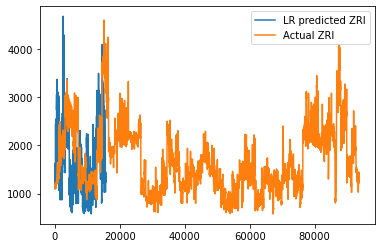

In [37]:
plt.plot(lr.predict(testX),label='LR predicted ZRI')
plt.plot(testY,label="Actual ZRI")
plt.legend()

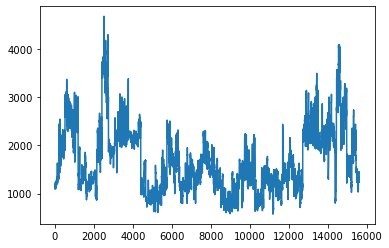

In [42]:
plt.plot(lr.predict(testX))

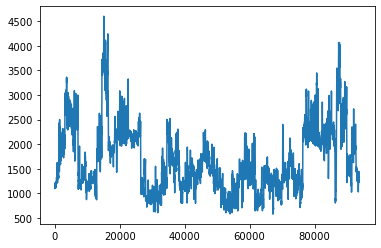

In [40]:
plt.plot(testY)

In [43]:
print('Logistic Regression')
print(f'R2: {lr.score(testX,testY)}')
print(f'RMSE: {sqrt(mean_squared_error(lr.predict(testX),testY))}')

Logistic Regression
R2: 0.9993837536383159
RMSE: 16.53807710757105


In [44]:
rf.fit(trainX,trainY)

RandomForestRegressor(random_state=1)

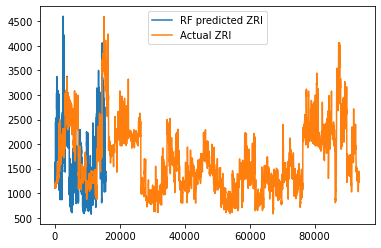

In [45]:
plt.plot(rf.predict(testX),label='RF predicted ZRI')
plt.plot(testY,label="Actual ZRI")
plt.legend()

In [46]:
print('Random Forest')
print(f'R2: {rf.score(testX,testY)}')
print(f'RMSE: {sqrt(mean_squared_error(rf.predict(testX),testY))}')

Random Forest
R2: 0.9993055429696656
RMSE: 17.556199923213228


In [47]:
print(f'Null model mean: {testY.mean()}')

Null model mean: 1668.3777287079706


In [48]:
testX

,zri_lag_1,zri_lag_2,zri_lag_3
60,1109.0,1115.0,1124.0
61,1099.0,1109.0,1115.0
62,1098.0,1099.0,1109.0
63,1106.0,1098.0,1099.0
64,1114.0,1106.0,1098.0
...,...,...,...
93739,1291.0,1294.0,1296.0
93740,1277.0,1291.0,1294.0
93741,1271.0,1277.0,1291.0
93742,1299.0,1271.0,1277.0


In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# define model
model = Lasso()

# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error',
                      cv=5, n_jobs=-1)
# perform the search
results = search.fit(trainX, trainY)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -9.283
Config: {'alpha': 0.0}


/Users/nikiagrawal/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/Users/nikiagrawal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/nikiagrawal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6540142.134095395, tolerance: 3242468.2830664306
  model = cd_fast.enet_coordinate_descent(


In [58]:
search.best_estimator_

Lasso(alpha=0.0)

In [52]:
lasso = Lasso(alpha=0)
lasso.fit(trainX,trainY)

<ipython-input-52-9ddd284c51d1>:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX,trainY)
/Users/nikiagrawal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/nikiagrawal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6540142.134095395, tolerance: 3242468.2830664306
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0)

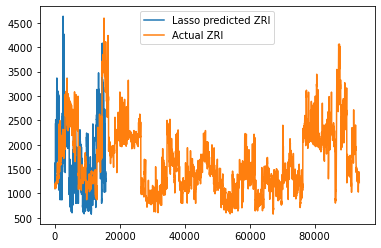

In [53]:
plt.plot(lasso.predict(testX),label='Lasso predicted ZRI')
plt.plot(testY,label="Actual ZRI")
plt.legend()

In [54]:
print('LASSO')
print(f'R2: {lasso.score(testX,testY)}')
print(f'RMSE: {sqrt(mean_squared_error(lasso.predict(testX),testY))}')

LASSO
R2: 0.9993729919606337
RMSE: 16.68185657682256


In [59]:
lasso.coef_

array([ 1.31727018, -0.22755404, -0.08936612])

# Add in ACS 

In [ ]:
# zri_lags_acs = pd.merge(zri,acs,how='left',left_on=["zip","year"],right_on=["zip","year_used"])
# zri_acs = zri_acs.drop(index=zri_acs[zri_acs['zip']=="11249"].index)